# Step 0: Import data and packages

In [0]:
# install packages
%%capture
!pip install -U gensim
!pip install pyLDAvis
!pip install vecstack

In [0]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections


from gensim import corpora
from gensim.models import ldamodel
from gensim.models.tfidfmodel import TfidfModel
from gensim.models.nmf import Nmf
from gensim.models import LsiModel, KeyedVectors
from gensim.matutils import corpus2dense
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim

from datetime import *
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from vecstack import stacking
from sklearn.linear_model import LinearRegression

In [0]:
# import data
%%capture
!wget https://cis.upenn.edu/~cis545/data/reviews.dict
!wget https://cis.upenn.edu/~cis545/data/train_reviews.mm
!wget https://cis.upenn.edu/~cis545/data/train_times.npy

In [0]:
# load the dictionary, reviews_bow and review times
reviews_dict = corpora.Dictionary.load("reviews.dict")
reviews_bow = corpora.MmCorpus('train_reviews.mm')
reviews_times  = np.load('train_times.npy')

In [0]:
# get the star rating
y = np.vstack((np.repeat(1, 4000), np.repeat(2, 4000), np.repeat(3, 4000), np.repeat(4, 4000), np.repeat(5, 4000)))
y = np.repeat(y, 5)

# Step 1: Exploratory Data Analysis

## Step 1.1: Review time analysis

In this part, we want to analyze the role of review times. We want to clarify 
two questions:
- whether the reviews are evenly distributed over all time granularity or not
- whether the review times effect the star rating or not





### Step 1.1.1: Distribution of Review over Time

In order to figure out the first question, we plot four distributions as follow:
- the distribution of review over years
- the distribution of review over months
- the distribution of review over days
- the distribution of review over year-month (e.g. 2012-02)

In [6]:
# define a function that convert the review_times into timestamp
def convert_times(reviews_times):
    res = []
    for timestamp in reviews_times:
        res.append(datetime.fromtimestamp(timestamp))
    res = pd.Series((r for r in res))
    return res
converted_times = convert_times(reviews_times)
converted_times

0       2012-05-06
1       2014-04-07
2       2012-07-17
3       2014-07-14
4       2013-05-16
           ...    
99995   2013-04-04
99996   2010-09-21
99997   2013-05-12
99998   2013-03-05
99999   2012-07-27
Length: 100000, dtype: datetime64[ns]

According to the following graph, we know that the review times start from 2001 and end in 2013. And **the numbers of reviews vary over years**. It is obvious that there are less reviews in early years and more reviews in recent years.

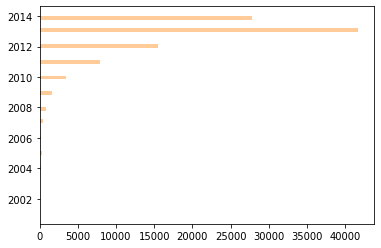

In [12]:
# plot the distribution of review times over years
converted_years = []
for time in converted_times:
    converted_years.append(time.year)
    
sns.distplot(converted_years, color='#ff8000',vertical= True,kde=False)
plt.show()

As the number of review in early year is not in the same level of magnitude, we use **increasing rate** to **normalize** the data and visualize as follows. From the following graph, we can figure out that, regardless of some outliers, **the number of reviews increase in a high speed, almost double the number each year**.

Text(0.5, 1.0, 'The increase rate of number of reviews from 2001 to 2014')

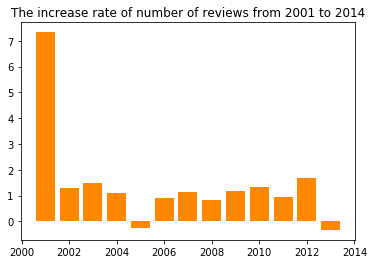

In [24]:
# plot the increase rate
# use the collections.Counter to get a dictionary, the key of which is the year, the value of which is the number of reviews in that year
count_year = collections.Counter(converted_years)
increase_rate = []
# calculate the increase_rate
for i in range(2001,2014):
    increase_rate.append((count_year[i+1]-count_year[i])/count_year[i])
    
plt.bar(range(2001,2014),increase_rate,color='#ff8800')
plt.title('The increase rate of number of reviews from 2001 to 2014')

According to the distribution of review over months, it is justified that **the numbers of review vary over month**. The numbers of review in August, September and Octorber are obviously less than other months. 

From the following analysis, we can discover that the main reason that leads to such result is in 2014, there is no review since August.

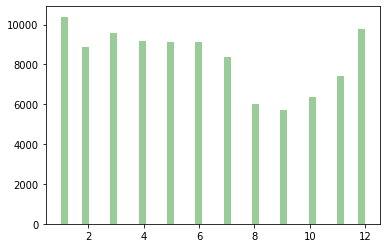

In [140]:
# plot the distribution of review times over months
converted_months = []
for time in converted_times:
    converted_months.append(time.month)
sns.distplot(converted_months, color='g',kde=False)
plt.show()

According to the distribution of review over days, we discover that **the reviews are almost evenly distributed over days**. 

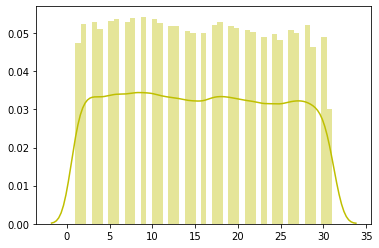

In [141]:
# plot the distribution of review times over days
converted_days = []
for time in converted_times:
    converted_days.append(time.day)
sns.distplot(converted_days, color='y')
plt.show()

In [0]:
# define a function that plot the distribution of review in the given year.
def year_distribution(year):
    # extract only year and month from converted_time
    year_month = converted_times.map(lambda x: x.strftime('%Y-%m'))
    year_month = year_month.tolist()
    # select the reviews in the given year
    year_month = [x for x in year_month if x[:4]==str(year)]
    # count the number of review in each month
    count = collections.Counter(year_month)
    x, y = [],[]
    # sort the dictionary
    for key,value in count.items():
        # extract month from '%Y-%m'
        x.append(key[5:])
        y.append(value)
    # sort the number of reviews by month, such that the x-axis will be ordered in month
    y = [y for x,y in sorted(zip(x,y))]
    x.sort()
    # plot the graph
    plt.bar(x, y, width=0.5, color='skyblue',alpha=0.5)
    plt.title('The distribution of review times over %s'%str(year))
    plt.show()

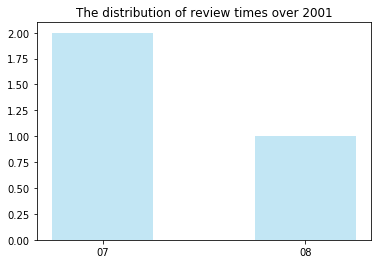

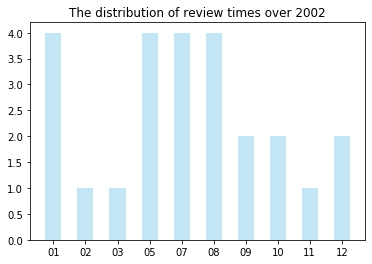

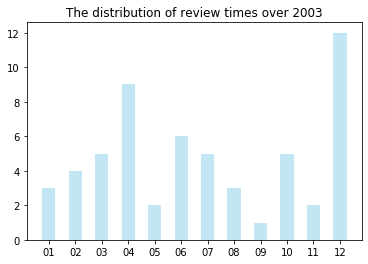

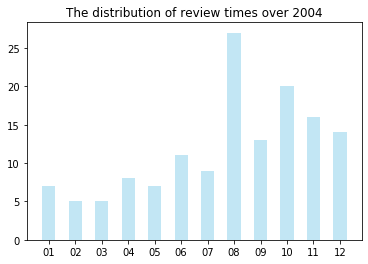

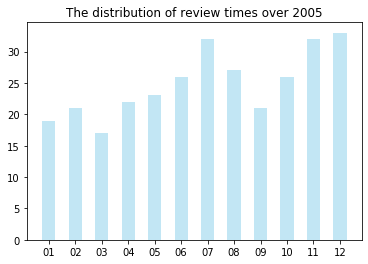

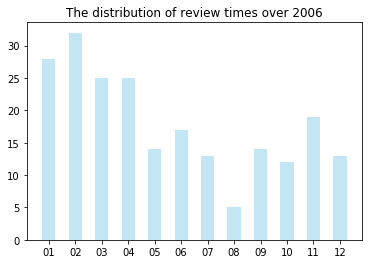

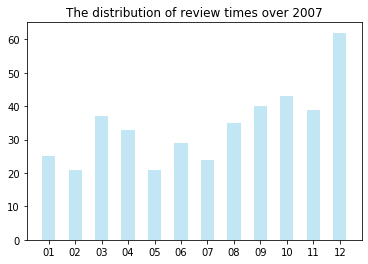

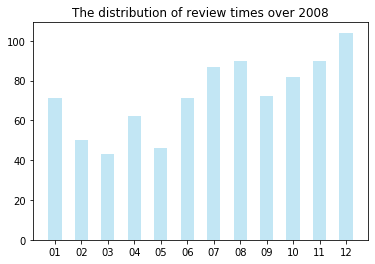

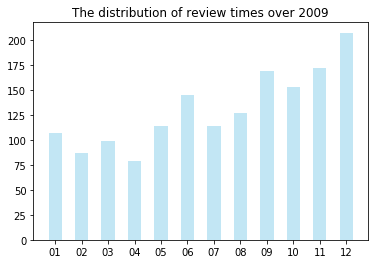

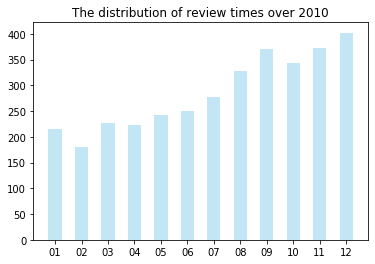

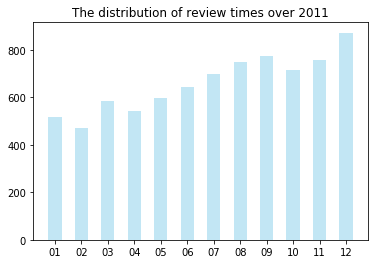

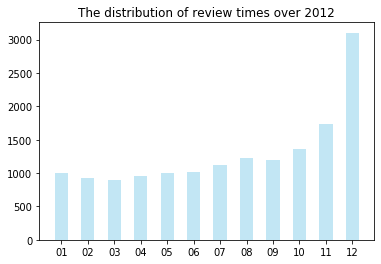

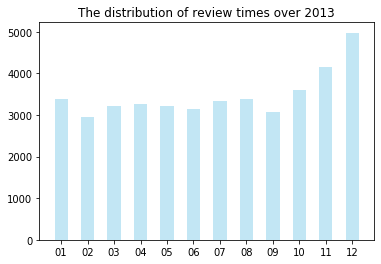

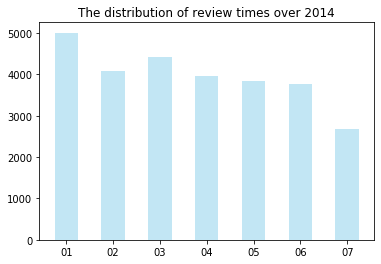

In [146]:
# plot the graph for each year from 2001 to 2014
for year in range(2001,2015):    
    year_distribution(year)

From the above graphs, we can discover:

1. There are some missing months in 2001 and 2014.
2. As the total numbers of reviews in the early years are limited (2001~2006), the distributions in these years cannot reflect the true pattern of real review times.
3. Since 2007, the distribution graphs show an apparent trend: **the closer to the end of year, the more reviews**.

### Step 1.1.2: Star rating over time

Before we analyze the star rating over time, we need to do some data wrangling.

In [0]:
# transfer y and converted_time into DataFrame
rating_df = pd.DataFrame(y,columns=['star_rating'])
review_time_df = pd.DataFrame(converted_times,columns=['review_time'])

In [0]:
# concatenate star rating and review times
rating_time_df = pd.concat([rating_df['star_rating'],review_time_df['review_time']],axis=1)

# derive year from review_time
rating_time_df['year'] = rating_time_df['review_time'].apply(lambda x:x.year)

# derive month from review_time
rating_time_df['month'] = rating_time_df['review_time'].apply(lambda x:x.month)

In [10]:
rating_time_df.head()

,star_rating,review_time,year,month
0,1,2012-05-06,2012,5
1,1,2014-04-07,2014,4
2,1,2012-07-17,2012,7
3,1,2014-07-14,2014,7
4,1,2013-05-16,2013,5


After we finish data wrangling, we can start to analyze how star rating change over times.

First of all, we begin with analyzing **how star rating varies over years**. Based on the following two graphs, we discover that:
- **In the early years, the average ratings are obviously lower than that of the recent year**. There are many potential reasons that may lead to such situation. For example, the number of reviews in the early years is not sufficient to represent the whole group. Or the service of Amazon improves over years.
- Although the average ratings over the recent years are almost the same, we can see in the Bubble Graph, **in each year, the numbers of reviews are not evenly distributed across the rating**. For example, in 2010 and 2011, the number of 3-star reviews is visibly less than the others. And in 2014, the numbers of 2-star and 4-star reviews are less than the others.  

Text(0.5, 1.0, 'The average rating over year')

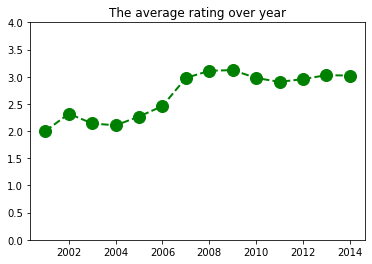

In [208]:
# calculate and plot the average rating over years
year_rating = rating_time_df[['year','star_rating']].groupby('year').mean().reset_index()
plt.plot(year_rating['year'],year_rating['star_rating'],color='green', marker='o',label = 'Year', linestyle='dashed',linewidth=2, markersize=12)
# set the range of y axis
plt.ylim(0,4)
plt.title('The average rating over year')

In [274]:
# count the number of reviews in each star rating, each year
year_count = rating_time_df[['year','star_rating','review_time']].groupby(['year','star_rating']).count().reset_index()
year_count = year_count.rename(columns = {'review_time':'count'})
year_count.head()

,year,star_rating,count
0,2001,2,3
1,2002,1,1
2,2002,2,21
3,2002,5,3
4,2003,1,2


Text(0.5, 1.0, 'The number of each rating from 2006 to 2014')

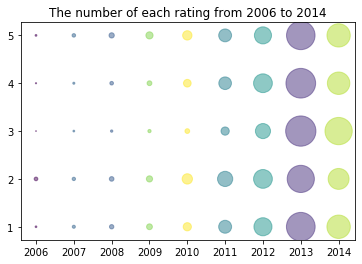

In [277]:
# plot the Bubble Graph and the size of bubble represents the number of reviews in that group

# as the number of reviews in early years is too small, we drop these years
year_count = year_count[year_count['year']>=2006]
# generate color set for each rating, repeat the color set for 5 times
colors = np.random.rand(9)
colors = np.repeat(colors,5)
plt.scatter(year_count['year'],year_count['star_rating'],s=year_count['count']/10,alpha = 0.5,c=colors)
plt.title('The number of each rating from 2006 to 2014')

We can repeat the above process to analyze **how the star rating varies over months.**

We can discover that:
- The average ratings make only trivial changes over the months.
- **In each month, the reviews are almost evenly distributed in different ratings**.

Text(0.5, 1.0, 'The average rating over months')

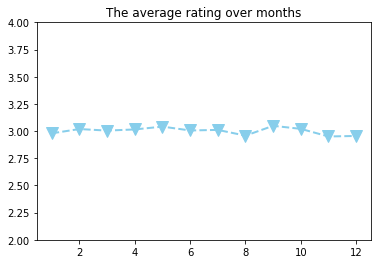

In [209]:
# calculate and plot the average rating over months
month_rating = rating_time_df[['month','star_rating']].groupby('month').mean().reset_index()
plt.plot(month_rating['month'],month_rating['star_rating'],color='skyblue', marker='v',label = 'Month', linestyle='dashed',linewidth=2, markersize=12)
plt.ylim(2,4)
plt.title('The average rating over months')

In [243]:
# count the number of reviews in each star rating, each year
month_count = rating_time_df[['month','star_rating','review_time']].groupby(['month','star_rating']).count().reset_index()
month_count = month_count.rename(columns = {'review_time':'count'})
month_count.head()

,month,star_rating,count
0,1,1,2103
1,1,2,2008
2,1,3,2266
3,1,4,2039
4,1,5,1981


Text(0.5, 1.0, 'The numbers of each rating over months')

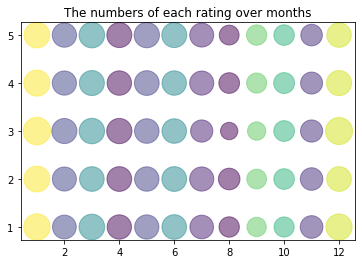

In [280]:
# plot the Bubble Graph
# the size of bubble represents the number of reviews in that group
colors = np.random.rand(12)
colors = np.repeat(colors,5)
plt.scatter(month_count['month'],month_count['star_rating'],s=month_count['count']/3,alpha = 0.5,c=colors)
plt.title('The numbers of each rating over months')

### Step 1.1.3: Conclusions

Based on the analysis in 1.1.1 and 1.1.2, we can conclude the role of review times.

1. The review times cover the period from 2001 to 2014. But the data of the first and last year is not completed. 
2. **The number of reviews vary across the year**. And it increases dramatically since 2007.
3. In general, as the review times get closer to the end of year, there are more reviews. Therefore, **it is reasonable to assume that, these reviews are from products which sells well in the end of year**.
4. **The distributions of star rating vary across the year, but remain almost the same across the month**.

According to the above conclusion, **if we want to predict/classify the star rating, we can try to add time variables - review_year, review_month into the model**.

## Step 1.2: Review topic analysis

### Step 1.2.1: TF-IDF Model

In this part, I try to use **LDA model** to discover the topic of each review. In this process, I use packages provided by gensim. ([Latent Dirichlet Allocation](https://radimrehurek.com/gensim/models/ldamodel.html))

Before I train the LDA model, I convert the counts into TF-IDF score as we did in HW4.([TF-IDF Model](https://radimrehurek.com/gensim/models/tfidfmodel.html))

In [0]:
# define a function that converts corpus into TF-IDF score
def make_tfidf(reviews_bow):
    model = TfidfModel(reviews_bow, normalize = True)
    vector = model[reviews_bow]
    return vector

# define a function that visualizes the distribution of the values in the bag of words
def plot_values(reviews, function=None):
    values = []
    for doc in reviews:
        for (word, score) in doc:
            if not function: values.append(score)
            else:            values.append(function(score))

    plt.hist(values - np.mean(values), bins='auto')
    plt.show()

In [0]:
reviews_tfidf = make_tfidf(reviews_bow)

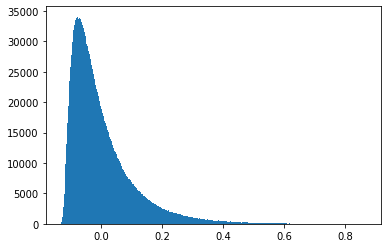

In [12]:
plot_values(reviews_tfidf)

### Step 1.2.2: LDA Model

When we train a LDA model, there is a very important hyperparameter `num_topics`. Thus, in order to pick up an optimal `num_topics`, we use `coherence score` to evaluate the performance of LDA model. ([CoherenceModel](https://radimrehurek.com/gensim/models/coherencemodel.html))

In [0]:
# define a function that returns the trained LDA model and coherence score 
def make_lda(reviews_tfidf,reviews_dict, num_topics):
    lda = ldamodel.LdaModel(reviews_tfidf, id2word = reviews_dict, num_topics = num_topics)
    cm = CoherenceModel(model=lda, corpus=reviews_tfidf, dictionary=reviews_dict, coherence='u_mass')
    coherence = cm.get_coherence() 
    return lda, coherence

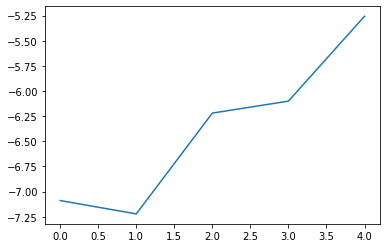

In [305]:
# find the optimal num_topics
num_topics = [10,20,30,40,50]
coherence = []
for num in num_topics:
    lda, score = make_lda(reviews_tfidf,reviews_dict, num)
    coherence.append(score)

plt.plot(coherence)

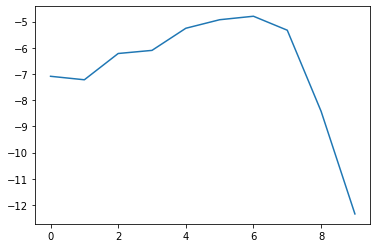

In [306]:
num_topics = [60,70,80,90,100]
for num in num_topics:
    lda, score = make_lda(reviews_tfidf,reviews_dict, num)
    coherence.append(score)

plt.plot(coherence)

From the above graph, we find the optimal `num_topics = 60`. Next, we use this hyperparameter to train LDA model and visualize the topics. 

In [307]:
lda, score = make_lda(reviews_tfidf,reviews_dict, 60)
lda.print_topics()

[(51,
  '0.056*"scent" + 0.053*"smell" + 0.017*"clean" + 0.016*"strong" + 0.014*"odor" + 0.013*"bathroom" + 0.012*"fragranc" + 0.012*"product" + 0.012*"use" + 0.011*"tool"'),
 (38,
  '0.024*"knife" + 0.016*"shower" + 0.015*"toilet" + 0.014*"exercis" + 0.010*"use" + 0.009*"son" + 0.008*"target" + 0.007*"roll" + 0.007*"clean" + 0.006*"work"'),
 (29,
  '0.043*"energi" + 0.039*"sleep" + 0.020*"night" + 0.017*"help" + 0.016*"husband" + 0.015*"take" + 0.015*"morn" + 0.013*"wake" + 0.011*"bed" + 0.011*"relax"'),
 (31,
  '0.082*"swallow" + 0.049*"awesom" + 0.043*"ball" + 0.023*"spare" + 0.020*"tough" + 0.018*"smaller" + 0.017*"vari" + 0.016*"great" + 0.015*"select" + 0.014*"chew"'),
 (44,
  '0.026*"job" + 0.017*"dirt" + 0.014*"style" + 0.014*"pump" + 0.014*"throughout" + 0.013*"messi" + 0.013*"own" + 0.011*"liner" + 0.010*"thread" + 0.010*"comfi"'),
 (32,
  '0.037*"strip" + 0.031*"mild" + 0.027*"length" + 0.022*"block" + 0.022*"bug" + 0.021*"wrap" + 0.020*"zero" + 0.019*"wont" + 0.018*"remedi"

### Step 1.2.3: Topics visualization

We can use `pyLDAvis` to visualize the topic and the most relevant terms in each topic. 

For example, when you select topic 11 in the left bubble graph, the right graph will show the Top-30 Most Relevant Terms for topic 11. Based on these high-frequence terms, we can name the topic 11 as `Health Product`. 

As there are so many topics in our review corpus, I cannot name every topic. But we can use this interactive graph to observe each topic. **Enjoy exploring the topics by yourself!**

In [311]:
pyLDAvis.enable_notebook()
visual = pyLDAvis.gensim.prepare(lda, reviews_tfidf, reviews_dict)
visual

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.236811 -0.006912       1        1  6.168599
38    -0.197164  0.007985       2        1  4.678828
52    -0.188209  0.027801       3        1  4.101347
54    -0.187459  0.027763       4        1  4.025940
41    -0.188509 -0.013569       5        1  3.844353
59    -0.215630 -0.041998       6        1  3.557945
40    -0.198428 -0.000716       7        1  3.279804
43    -0.192955 -0.012041       8        1  3.030265
10    -0.181198  0.015715       9        1  2.794389
15    -0.174697  0.028613      10        1  2.730137
5     -0.167929 -0.154591      11        1  2.712142
51    -0.187017 -0.003292      12        1  2.507739
42    -0.154824  0.022429      13        1  2.498241
6     -0.174774  0.037234      14        1  2.448549
2     -0.180264 -0.000256      15        1  2.446545
39    -0.139914  0.043777      16        1  2.184052
29    -0.161852 -0.013690      17        1  2.120978
44    -0.126989  0.073152      18        1  1.933206
35    -0.130709 -0.146380      19        1  1.914508
31    -0.039020  0.082014      20        1  1.511074
14    -0.079900  0.041860      21        1  1.472734
53    -0.075673 -0.030417      22        1  1.449193
46     0.033552 -0.032323      23        1  1.389584
3     -0.018598  0.079150      24        1  1.384761
8     -0.079179  0.071261      25        1  1.351078
32     0.030050  0.093431      26        1  1.244097
25    -0.052815  0.027747      27        1  1.220880
49    -0.004504  0.011911      28        1  1.191940
36    -0.003196 -0.075404      29        1  1.186935
9     -0.081412  0.003080      30        1  1.181888
19     0.009397  0.052320      31        1  1.135562
0      0.123391 -0.007288      32        1  1.121842
16     0.025380 -0.165998      33        1  1.110318
4      0.006665 -0.032376      34        1  1.107657
17    -0.073999  0.037841      35        1  1.099742
20    -0.025136 -0.069403      36        1  1.089040
1     -0.002803  0.050010      37        1  1.075792
13     0.130972  0.048272      38        1  1.026112
24     0.141782  0.123225      39        1  0.992072
33     0.138686 -0.068500      40        1  0.950032
34     0.086571 -0.011928      41        1  0.949004
27     0.015331 -0.089391      42        1  0.945795
47     0.075130  0.005177      43        1  0.940393
12     0.036443  0.085260      44        1  0.915047
26     0.189596  0.051404      45        1  0.886655
37     0.007131  0.038904      46        1  0.884065
57     0.171592  0.058894      47        1  0.833438
55     0.188116  0.035872      48        1  0.828961
58     0.113744 -0.190131      49        1  0.813463
21     0.207153  0.030781      50        1  0.791069
23     0.196446 -0.098627      51        1  0.757131
7      0.219596 -0.057101      52        1  0.756928
30     0.178145  0.002643      53        1  0.727554
18     0.232602  0.005686      54        1  0.715440
45     0.241299  0.012789      55        1  0.708260
48     0.206686 -0.050551      56        1  0.695895
22     0.201574  0.034308      57        1  0.683890
28     0.220954 -0.021926      58        1  0.653175
50     0.232885 -0.008953      59        1  0.652832
56     0.260697  0.035456      60        1  0.591112, topic_info=     Category         Freq        Term        Total  loglift  logprob
278   Default  1081.000000       shave  1081.000000  30.0000  30.0000
158   Default  1131.000000     batteri  1131.000000  29.0000  29.0000
1807  Default   794.000000  supplement   794.000000  28.0000  28.0000
496   Default   917.000000        pill   917.000000  27.0000  27.0000
1543  Default  1109.000000        tast  1109.000000  26.0000  26.0000
...       ...          ...         ...          ...      ...      ...
3592  Topic60     0.210558        tout     1.575648   3.1183  -9.4765
3086  Topic60     3.954721       advic    66.464005   2.3092  -6.5436
1322  Topic60     5.731066        forc   

# Step 2: Modelling

## Step 2.1: Data wrangling

### Step 2.1.1: Dimensionality reduction

If the dimension of our feature set is too high, it will lead to the `Curse of dimensionality` in our future modelling part. Therefore, we have to reduce the dimension.

The method we try is `PCA` and as what we do in HW4, we use `LsiModel` built in `gensim`.([LsiModel](https://radimrehurek.com/gensim/models/lsimodel.html)) 

In [0]:
def plot_variance_vs_components(singular_values):
    evr = np.array([singular_values[i]**2 / sum(singular_values**2) for i in range(len(singular_values))])
    var = np.cumsum(evr*100)
    plt.ylabel('% Variance Explained')
    plt.xlabel('# of Components')
    plt.title('PCA Analysis')
    plt.style.context('seaborn-whitegrid')
    plt.plot(var)

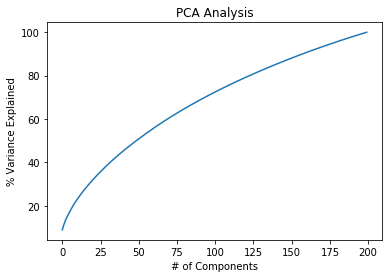

In [50]:
# plot the variance explained when the number of topics is 200  
model = LsiModel(reviews_tfidf, id2word=reviews_dict,num_topics=200)
singular = model.projection.s
plot_variance_vs_components(singular)

In above graph, we cannot find obvious elbow. Therefore, we increase the `num_topics` to 3000. Then, we find an obvious elbow in the plot. Therefore, I pick up the `num_topics = 2000`, which explains more than 90% of the variance.

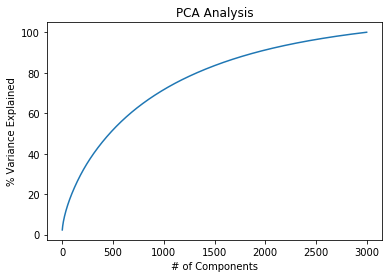

In [15]:
# plot the variance explained when the number of topics is 3000  
model = LsiModel(reviews_tfidf, id2word=reviews_dict,num_topics=3000)
singular = model.projection.s
plot_variance_vs_components(singular)

In [16]:
# calculate the variance explained proportion if we use num_topics = 2000
sum(singular[:1999]**2) / sum(singular**2)

0.9121278475694544

### Step 2.1.2: Densify the review

After we finished the dimension reduction part, we have to densify our `reviews_bow`, such that for each review, it has same dimensions. 

In [0]:
# densify the review_vectorized use built-in function corpus2dense
model_selected = LsiModel(reviews_tfidf, id2word=reviews_dict,num_topics=2000)
review_vectorized = model_selected[reviews_tfidf]
review_dense = corpus2dense(review_vectorized, 2000)

In [12]:
review_dense = review_dense.transpose()
review_dense.shape

(100000, 2000)

In [13]:
review_dense

array([[ 0.14463565,  0.06514698, -0.09490672, ..., -0.00526171,
         0.01371014, -0.00035722],
       [ 0.10408664,  0.06224889, -0.00354843, ...,  0.00155335,
        -0.00236687, -0.00731847],
       [ 0.13481076, -0.0186753 ,  0.01665152, ...,  0.00323746,
        -0.00818044,  0.00416718],
       ...,
       [ 0.13637486,  0.01634526, -0.00903381, ..., -0.00276208,
         0.00386437,  0.00195268],
       [ 0.06231232,  0.00931309,  0.01789374, ..., -0.00848548,
         0.00835384,  0.01951185],
       [ 0.07765084, -0.01514619,  0.02758767, ..., -0.00610544,
        -0.0082877 , -0.00280275]], dtype=float32)

## Step 2.2: Feature selection

After we finish the data wrangling part, we need to determine what features we want to put into our final model. 

The derived features we have from the given data set are mainly time-related features, such as `year, month`. 

The idea behind this feature selection part is simple. We try different feature sets on the same algorithm - Logistic Regression and find the feature set that gives us the best result.

In [0]:
review_df = pd.DataFrame(review_dense)

In [12]:
review_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.144637,0.065157,-0.094960,0.059578,0.087343,0.019436,-0.044969,-0.070978,-0.073978,0.081097,0.036369,-0.018382,0.018122,0.020354,-0.052698,-0.049986,0.030455,0.046797,-0.004611,-0.018507,-0.061113,0.002807,-0.014611,0.004339,0.066321,-0.040743,-0.012665,-0.003981,-0.031343,0.013366,0.013394,-0.010573,-0.047984,0.066933,0.046976,0.084323,-0.102991,0.091470,0.030639,0.190033,...,0.016159,-0.001978,-0.001688,-0.011776,-0.001301,-0.004019,0.003345,0.002362,-0.004703,-0.007248,-0.005041,0.001840,0.003603,0.001148,-0.001033,0.003061,-0.005250,-0.000039,-0.002529,-0.002929,-0.007398,-0.006196,-0.004705,-0.003354,0.005121,0.014926,0.004506,-0.001744,-0.009554,0.005455,-0.003220,-0.003274,-0.008606,-0.008958,-0.004883,0.003503,-0.008812,-0.001057,-0.011090,-0.005293
1,0.104080,0.062204,-0.003541,0.022864,-0.061908,0.032901,0.054465,-0.024313,0.012809,0.034612,0.002190,0.021191,0.052190,0.001319,0.018577,0.034041,-0.031492,-0.026327,-0.039763,-0.017323,-0.084355,-0.001416,-0.021170,-0.072189,0.053645,0.050978,0.043515,0.037570,-0.015900,0.009200,0.080463,-0.012310,0.072017,-0.139526,0.079105,-0.114971,0.059112,-0.000245,-0.037187,0.020964,...,0.017279,0.010749,-0.007374,0.002514,-0.011009,-0.000152,0.008815,-0.004344,0.000008,0.026551,0.003478,0.004504,-0.008066,-0.007112,-0.012313,-0.012308,-0.010310,0.004217,0.015798,0.013851,0.007397,0.007819,0.005850,-0.007392,0.013522,0.026472,0.007329,0.009402,-0.004670,-0.001258,0.010959,0.000182,0.006249,-0.007927,0.021893,-0.007996,0.001480,0.009168,-0.010159,0.008772
2,0.134818,-0.018654,0.016629,-0.011075,-0.040578,-0.028595,-0.018743,-0.002928,0.016649,0.008272,0.082777,-0.020569,0.006028,0.000597,-0.073681,0.020242,-0.089568,0.064821,0.087380,-0.005581,-0.019369,0.101297,-0.032286,-0.092056,0.063490,0.020696,-0.050097,-0.052461,-0.033966,-0.042829,-0.016684,-0.111145,-0.121673,-0.050383,0.013461,0.021310,-0.053111,-0.042744,0.008341,-0.129591,...,0.004958,-0.010000,-0.006269,0.005332,-0.006111,0.000672,-0.004896,-0.003017,0.000741,-0.005234,0.004213,0.003963,0.003816,0.007572,0.000495,-0.002736,0.000069,-0.004301,-0.005369,-0.000321,0.006146,0.003496,-0.002032,-0.004638,0.002286,-0.002400,-0.003402,0.006711,-0.005705,-0.000367,-0.008717,0.005469,-0.005388,0.000178,-0.010222,0.004745,-0.003341,-0.001096,0.002078,-0.002117
3,0.105177,0.031616,0.056614,-0.006470,-0.045209,0.030856,0.038277,-0.057864,-0.018046,0.017842,-0.004470,-0.044605,0.010050,-0.016039,0.016627,0.020309,0.032422,-0.028904,0.019180,0.016334,-0.007032,0.000895,-0.022735,-0.012495,-0.030636,-0.016815,-0.024739,-0.013447,0.007168,-0.000714,-0.020500,-0.015270,-0.032851,-0.014738,0.014287,-0.023833,0.008699,0.026046,0.009287,0.006753,...,-0.002150,-0.009886,0.000581,-0.004116,-0.000282,-0.007302,-0.002136,-0.013049,-0.004473,-0.006004,-0.010935,-0.009741,0.001180,0.000773,-0.014660,0.001777,-0.008037,-0.011219,-0.008802,0.010129,-0.005487,-0.003514,0.015182,-0.006208,-0.002176,-0.006313,-0.012555,0.006403,-0.000925,0.009887,0.016299,-0.002100,-0.005466,0.001761,-0.000351,0.000088,0.001447,-0.002590,-0.003202,0.007586
4,0.063249,-0.001722,0.022943,0.000425,0.006475,0.014635,-0.031782,0.009524,0.009709,0.010862,0.016070,-0.006296,0.023559,0.011199,0.076796,0.027144,0.018737,-0.017451,-0.054316,0.017918,0.004151,0.014671,0.013404,-0.052224,0.025181,-0.038019,-0.068971,0.035101,-0.063604,0.056163,-0.052466,0.018873,0.026173,-0.031600,-0.044115,0.038894,-0.005165,-0.039094,-0.009169,0.015393,...,-0.006599,-0.001511,0.005079,-0.000534,0.000481,-0.009073,0.003017,0.002510,-0.000365,0.000790,-0.001369,-0.000998,-0.000407,-0.003074,0.000866,0.002719,-0.000325,-0.001533,-0.000635,-0.001213,-0.004737,-0.003707,-0.000666,-0.00

In [0]:
# test the model without any time-related feature
X_no_time = review_df
X_no_time_train, X_no_time_test, y_train, y_test = train_test_split(X_no_time, y, test_size=0.2, random_state = 1911)
lr_no_time = LogisticRegression(solver='saga').fit(X_no_time_train,y_train)

In [31]:
score_no_time = lr_no_time.score(X_no_time_test,y_test)
print('The score of Logistic regression with no time variables is '+str(score_no_time))

The score of Logistic regression with no time variables is 0.8653


After we try the model without any time-related variables, we can add the year and month to our feature set sequentially. This method is known as `stagewise regression`. But before that, we should do `one-hot encoding` for `year` and `month`, for they are both `categorial variables`.

In [0]:
# do one-hot encoding for year and month
year_df = pd.get_dummies(rating_time_df['year'])
month_df = pd.get_dummies(rating_time_df['month'])

In [0]:
# test the model with year
X_year = pd.concat([review_df,year_df],axis=1)
X_year_train, X_year_test, y_train, y_test = train_test_split(X_year, y, test_size=0.2, random_state = 1911)
lr_year = LogisticRegression(solver='saga').fit(X_year_train,y_train)

In [36]:
score_year = lr_year.score(X_year_test,y_test)
print('The score of Logistic regression with year is '+str(score_year))

The score of Logistic regression with year is 0.86465


Compare with the scores of model that has `year` variable and model that does not have, we find that **adding `year` cannot improve our model performance. Therefore, we drop the `year` variable**. Then, we try `month` using the same method. 

In [0]:
# test the model with month
X_month = pd.concat([review_df,month_df],axis=1)
X_month_train, X_month_test, y_train, y_test = train_test_split(X_month, y, test_size=0.2, random_state = 1911)
lr_month = LogisticRegression(solver='saga').fit(X_month_train,y_train)

In [38]:
score_month = lr_month.score(X_month_test,y_test)
print('The score of Logistic regression with month is '+str(score_month))

The score of Logistic regression with month is 0.86505


Based on the scores of three models, we find that **both `year` and `month` variables cannot improve the performance of our Logistic Regression**. Therefore, **we drop these two variables and keep only review data in our feature set**.

(0.86, 0.87)

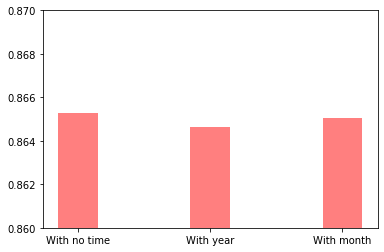

In [54]:
# compare the scores of three models
scores = [score_no_time,score_year,score_month]
label=['With no time','With year','With month']
plt.bar(label,scores,color='r',alpha = 0.5,width=0.3)
plt.ylim(0.86,0.87)


## Step 2.3: Model selection

Now, we have finished our data preparation part and start to train our model. Before that, we should consider a problem: **should star ratings remain as a categorical variable or is it better to reformulate this as a regression problem?**

As the predicted variable `star rating` is discrete, it is natural to regard this problem as a classification model. But let us think over the difference of loss function of classification and regression problem. If we use classification model to train the data, we treat all misclassified behavior equally. 

In detail, for the `classifier A` which misclassifies `star rating = 1` as `star rating = 5`, and the `classifier B`, which  misclassifies `star rating = 4` as `star rating = 5`, it is obviously that A is more wrong than B. But in classification model, we will take them as the same. However, in regression model, the `L2 Error` of A is 4**2=16, but the `L2 Error` of B is 1, which indicated that B outperforms than A. This is just what we expect.

**Therefore, We have to reformulate this as a regression problem.**

Next, we will try various regression models on our data set, including `Linear Regression, Random Forest Regression, XGBoost Regression` and so on. Finally, we try to find the optimal model that gives us the highest accuracy.

In [0]:
# get our final train set and test set
X = review_df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1911)

### Step 2.3.1: Ridge regression

The first regresion model we try and also our baseline method is `ridge regression`. In ridge regression, the regularization method we use is `L2 Penality`. And in order to select the best `Regularization strength - alpha`, we train a 5-fold cross validation and pick up the `alpha` that results in the lowest `Mean Squared Error`, also the highest Negative MSE.

The following result shows that the optimal hyperparameter `alpha = 2`.

In [0]:
# train a linear regression model
alpha = [0.1,0.5,1,2,5]
r_score = []
mse_lr = []
for a in alpha:
    lr = Ridge(alpha = a, random_state = 0,solver = 'auto').fit(X_train,y_train)
    r_score.append(lr.score(X_test,y_test))
    mse_lr.append(np.mean(cross_val_score(lr, X_train, y_train, cv=5, scoring='neg_mean_squared_error')))

Text(0.5, 1.0, 'The Negative MSE of Ridge Regressions')

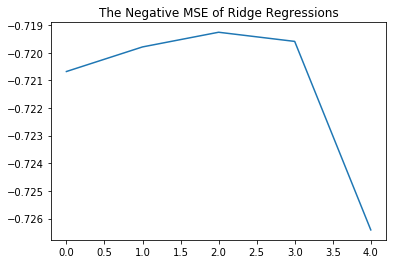

In [85]:
# plot the line of negative MSE
plt.plot(mse_lr)
plt.title('The Negative MSE of Ridge Regressions')

Text(0.5, 1.0, 'The R Square of Ridge Regressions')

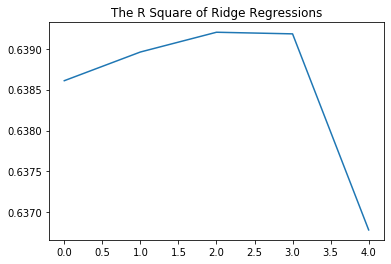

In [86]:
# plot the line of r square
plt.plot(r_score)
plt.title('The R Square of Ridge Regressions')

### Step 2.3.2 Random Forest regression

Before we try `Random Forest Regression`, we first try `Decision Tree Regression`, for we want to determine some important hyperparameters, such as `max_depth`, `max_features`.



In [14]:
# use GridSearchCV to find the optimal parameters combination
parameters = {'max_depth':[5,8,10,12,15], 'max_features':[0.3,0.5,0.8,1]}
dt_reg = DecisionTreeRegressor(random_state=0)
dt_reg = GridSearchCV(dt_reg, parameters,scoring='neg_mean_squared_error')
dt_reg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=0,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 8, 10, 12, 15],
                         'max_features': [0.3, 0.5, 0.8, 1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             s

In [16]:
# display the best parameters
dt_reg.best_params_

{'max_depth': 8, 'max_features': 0.8}

Then, we will try Random Forest Regression with the hyperparameter we found in DecisionTree Regression `max_depth = 8` and `max_features = 0.8`.

In [0]:
rf_reg = RandomForestRegressor(n_estimators = 50, random_state = 0, max_depth = 8,max_features= 0.8)
rf_reg = rf_reg.fit(X_train,y_train)
y_rf = rf_reg.predict(X_test)
mse_rf = mean_squared_error(y_test,y_rf)

In [15]:
mse_rf

0.8636018479510822

According to the above result, we can figure out the `Ramdom Forest Regression` greatly improve the MSE compared with `Ridge Regression`.

### Step 2.3.3: XGBoost regression

`XGBoost` is also one of ensembled algorithm. It makes some modification on `Gradiant Boosting Decision Tree` (GBDT) and it is known for its efficiency and high performance.

Here, we also can use `GridSearchCV` to find the best hyperparameter set.

In [0]:
# define a pipeline function that help us tune the hyperparameters
def pipeline(reg, X_train, X_test, y_train, y_test):
    print(str(reg))
    reg = reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test) 
    mse = mean_squared_error(y_test,y_pred)
    print('----- Model Peformance----')
    print('The Mean Squared Error is '+ str(mse))

In [19]:
# tuning for gamma
for gamma in [0.5,1]:
    xgb_reg = XGBRegressor(max_depth=5, n_estimators=30,booster='gbtree',random_state=0,gamma=gamma)
    pipeline(xgb_reg, X_train, X_test, y_train, y_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=30,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
[17:02:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----- Model Peformance----
The Mean Squared Error is 0.8616118548985622
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=30,
             n_jobs=1, nthread=None, 

According to the above model performance output, there is no big difference for different `gamma`. Therefore, I choose `gamma = 0.5`. And now, we can put `gamma = 0.5` into our next model and continue tuning for learning rate - `eta`.

In [21]:
# tuning for eta - learning rate
for eta in [0.01,0.1,0.2]:
    xgb = XGBRegressor(max_depth= 5, n_estimators = 30, booster='gbtree',random_state=0, gamma = 0.5, eta = eta)
    pipeline(xgb,X_train, X_test, y_train, y_test)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.01, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=30,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
[17:19:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
----- Model Peformance----
The Mean Squared Error is 0.8616118548985622
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0.5,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=30,
             n_j

The above result shows that the `eta` makes only trivial influence on our model, so we can just use the default value.  

As our time and computation power is limited, we choose not to continue tuning for this XGBoost model. But if it is possible, we can continue to tune for other hyperparameters, such as `alpha`, `n_estimators`,`max_depth`,`max_subsamples` and so on. And one of the convenient method to tune is `GridSearchCV` as follows.

In [0]:
# greedy search the best hyperparameter combination
# parameters = {'eta':[0.05,0.1,0.3,0.5,1], 'alpha':[0.5,1,2]}
# xgb_reg = XGBRegressor(max_depth=8, n_estimators=80,booster='gbtree',random_state=0)
# xgb_reg = GridSearchCV(xgb_reg, parameters,scoring='neg_mean_squared_error',cv=3)
# xgb_reg.fit(X_train, y_train)

# Step 3: Model ensemble

In this part, we try two different model ensemble methods. 

The first one is very simple. We calculate the `weighted average` of three models given by the aboving analysis. And the weight is decided by the NMSE(negative mean square error). For **the model that has higher NMSE, it will have higher proportion in the final result and vice versa**.

The second method is `stacking`. **This method takes the predictions of base model as the features for final predictions**.

If you want to look over more ensemble methods, you can look up the document [Comprehensive Guide for Ensembel Models](https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/).

## Step 3.1: Weighted Average

In [0]:
# train the models
model_ridge = Ridge(alpha = 2, random_state = 0,solver = 'auto').fit(X_train,y_train)
# model_rf = RandomForestRegressor(n_estimators = 50, random_state = 0, max_depth = 8,max_features= 0.8)
model_rf = rf_reg
model_xgb = xgb_reg
# model_xgb = XGBRegressor(max_depth=5, n_estimators=30,booster='gbtree',random_state=0, gamma = 0.5)

In [0]:
# get the predicted value of each model
y_ridge = model_ridge.predict(X_test)
# y_rf = model_rf.predict(X_test)
y_xgb = model_xgb.predict(X_test)

In [0]:
# get the weight of each model
nmse_lr = -1*mean_squared_error(y_test, y_ridge)
nmse_rf = -1*mse_rf
nmse_xgb = -1*mean_squared_error(y_test, y_xgb)
nmse = [nmse_lr, nmse_rf, nmse_xgb]
weights = [nmse[i]/sum(nmse) for i in range(3)]

In [0]:
# get the predicted value of ensembled model
y_pred = weights[0]*y_ridge + weights[1]*y_rf + weights[2]*y_xgb

In [29]:
# calculate the mean squared error of ensembled model
mean_squared_error(y_test,y_pred)

0.7368232461594083

It shows that **the weighted average can improve the performance of our model**. It decreases the MSE compared with Random Forest and XGBoost.

## Step 3.2: Stacking

In this stacking model, we only create two levels.

The above three models are built at level one, while a `Linear regression` model is built at level two. 

In [0]:
# combine the above models into models
models = [model_ridge, model_rf, model_xgb]

In [19]:
# get the train set and test set after stacking
S_train, S_test = stacking(models, X_train, y_train, X_test, regression= True, mode='oof_pred_bag', needs_proba=False, save_dir=None, metric=mean_squared_error, 
                           n_folds=3, stratified=True, shuffle=True, random_state=0, verbose=2)
                     

/usr/local/lib/python3.6/dist-packages/vecstack/core.py:461: UserWarning: This is regression task hence classification-specific parameters set to <True> were ignored: <stratified>
  warnings.warn(warn_str, UserWarning)


task:         [regression]
metric:       [mean_squared_error]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [Ridge]
    fold  0:  [0.71737768]
    fold  1:  [0.71728177]
    fold  2:  [0.73637316]
    ----
    MEAN:     [0.72367754] + [0.00897725]
    FULL:     [0.72367738]

model  1:     [RandomForestRegressor]
    fold  0:  [0.83559634]
    fold  1:  [0.84747794]
    fold  2:  [0.86536837]
    ----
    MEAN:     [0.84948088] + [0.01223662]
    FULL:     [0.84948069]

model  2:     [XGBRegressor]
[21:20:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  0:  [0.84161176]
[21:25:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  1:  [0.84720074]
[21:29:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
    fold  2:  [0.86873860]
    ----
    MEAN: 

In [0]:
# use linear regression to train the second level
stacking_lr = LinearRegression().fit(S_train,y_train)
y_pred_stack = stacking_lr.predict(S_test)


In [36]:
# get the MSE of the predicted value after stacking
mean_squared_error(y_test,y_pred_stack)

0.6712935420787477

Wooo ~ ~ ~ 

**The stacking continues to decrease our MSE! Therefore, we finally pick up this model.**

# Step 4: Conclusion

In the above notebook, we mainly complete two parts:
- We try to explore the data set and find some interesting insights about the original data.
- We try different regression algorithms and ensemble methods to construct a model that can predict the star rating.

First of all, let us look into our original data set. The number of reviews in each star rating is the same. Obviously, the professor used **stratified sampling method to get a subsample of a big data set**. Moreover, **the data set is not up-to-date**, for the latest review was in July 2014. And we also discover some interesting insights, such as **the number of reviews increases rapidly in these years** and in each year, **the more closer to the end of year, the more reviews**. Based on these finds, it is justified to make assumptions that in recent years, the service of Amazon gets better so that more people are willing to shop in Amazon and the average star rating also increases. And at the end of the year, people tends to shop more. Or these reviews are for some categories that are popupar at the end of year. If you are interested in these findings, you can go to `Step 1.1`. 

Besides the above analysis towards the role of review times. I also do topic analysis over Amazon reviews. **I build a LDA model and divided the reviews into 60 topics**. Through analyzing the most relevant terms of each topic, I discover some topics, such as **Health product, Gift, Gloves, Hair Product, Protein and so on**. Of course these are not all the topics. If you are interested in the other topics, **I strongly recommend you to go back to `Step 1.2` and try that great interactive visualization**!

After the exploratory analysis, I start to build the model. First of all, I use `Stagewise Regression` to decide whether I need to put the time variables - `year` and `month` into our model. The result shows that **these two features make no positive effect on our model performance**. After that, I analyze the divergence of classification and regression. I discover that the loss function of regression can better fit our purpose. Therefore, **although the accuracy of Logistic Regression has already achieved 0.8653, I still reformulate this problem as a `Regression Problem`**. 

In this regression problem, the metric I use to evaluate the performance of regression model is **`Mean Squared Error`**. After carefully comparisons between algorithms and hyperparameters, **the final model I choose is an `ensembled model` that consists of three models - Ridge regression, Random Forest Regression and XGBoost Regression.** **The final Mean Square Error is 0.67.** If you are interest in the detail of modelling, you can go back to the `Step 2`.

There are still a lot of work we can make to improve our model performance, especially the tuning part. But due to the limitation of computation power and time, I have to stop here. Maybe in the future, we can try more hyperparameter sets and more algorithm to make our model better.

Finally, I want to share some of my learning in this process. In this project, I independently complete a data science project, from exploratory analysis, data wrangling, to feature engineering and modelling. I feel so excited because I get opportunity to try various algorithms, ensemble techniques and python packages. Particularly, this is the first time I try to handle text data. This project helps me learn the basic idea of Natural Language Processing, which will benefit me in my future study and works.

I am proud of myself. And I hope all of you enjoy this notebook. **Most important, thank you all :)**

